In [1]:
using Gen
using PyPlot
using Revise
include("../src/utils.jl")
include("../src/model.jl")

dynamics_model

# Gravity

One of the MCS intuitive physics tasks relates to reasoning about gravity.

Under the forces-based model, gravity is naturally expressed as `const_a` that is passed into our model.

### Dropping the ball

Let's set up a scenario. A ball is dropped from rest at a height of 1.1, and gravity set to -0.022.

In [9]:
# model args
T = 10
dropped_from_height = State((0,1.1),(0,0),(0,0))
gravity_accel = (0, -0.022)
hypers = Hypers(0.001, 0.01)
model_args = (T, dropped_from_height, gravity_accel, hypers);

Next, we visualize some traces from the prior:

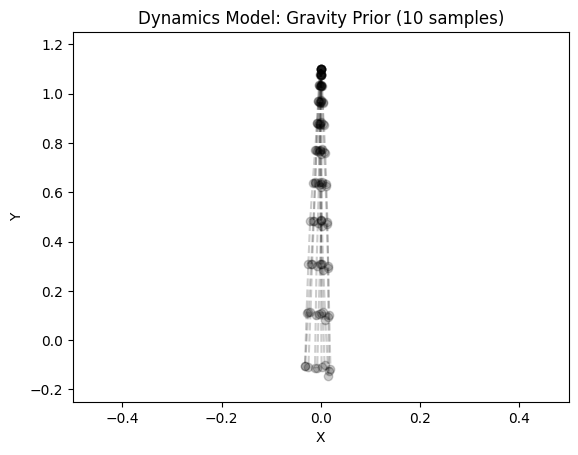

In [10]:
# set plotting parameters
init_drop_plot(subtitle) = init_occluder_scene(nothing, subtitle;
        plot_bounds=(xmin=-0.5,ymin=-0.25,xmax=0.5,ymax=1.25),
        occluder_bounds=(xmin=-0.2,ymin=0,xmax=0.2,ymax=1))

# plot dropping object
num_traces_to_visualize = 10
fig, ax = init_drop_plot("Gravity Prior ($num_traces_to_visualize samples)")
traces = [first(Gen.generate(dynamics_model, model_args)) for _ in 1:num_traces_to_visualize]
(tr -> draw_trace!(ax, tr)).(traces);

### Shoot for the stars

In this case, with the same gravity let's throw an object up and to the right at a velocity of (0.6, 1).

In [11]:
# model args
T = 20
toss_to_right = State((0,0), (0.1, 0.2), (0,0))
gravity_accel = (0, -0.022)
hypers = Hypers(0.0075, 0.01)  # σ_accel, σ_obs
model_args = (T, toss_to_right, gravity_accel, hypers);

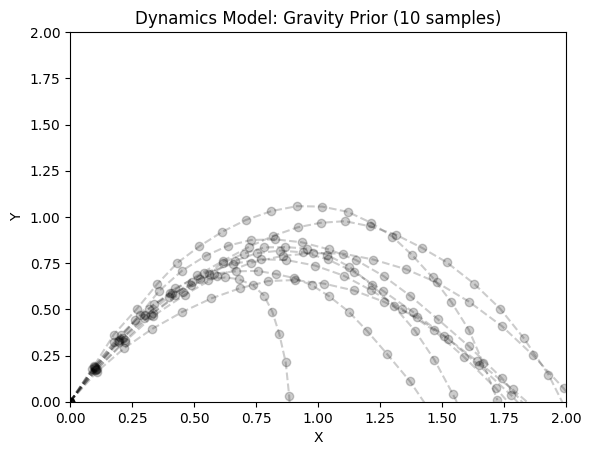

In [13]:
# set plotting parameters
init_toss_plot(obs, subtitle) = init_occluder_scene(obs, subtitle;
        plot_bounds=(xmin=0,ymin=0,xmax=2.0,ymax=2.0),
        occluder_bounds=(xmin=0,ymin=0,xmax=0.2,ymax=1))

# plot tossed object
num_traces_to_visualize = 10
fig, ax = init_toss_plot(nothing, "Gravity Prior ($num_traces_to_visualize samples)")
prior_traces = [first(Gen.generate(dynamics_model, model_args)) for _ in 1:num_traces_to_visualize]
(tr -> draw_trace!(ax, tr)).(prior_traces);

and finally, we'll noisily observe the end state of the ball, and visualize some samples from an importance weighted approximate posterior over trajectories.

In [ ]:
# observed end point
obs_x = 1.2
obs_y = 0.3
constraints = Gen.choicemap()
constraints[:obs => :x] = obs_x
constraints[:obs => :y] = obs_y

# importance sampling
num_top_traces_to_visualize = 100
num_is_samples = 10000
fig2, ax = init_toss_plot((obs_x, obs_y), "Posterior Approximation")
(post_traces, log_norm_weights, lml_est) = importance_sampling(dynamics_model, model_args, constraints, num_is_samples)
probs = exp.(log_norm_weights)
lines, = (tr -> draw_trace!(ax, tr; color="maroon")).(prior_traces)
lines[end].set_label("Prior samples")
lines, = (tr -> draw_trace!(ax, tr; color="black")).(post_traces[[categorical(probs) for _ in 1:100]])
lines[end].set_label("Samples from IS weighted posterior ($num_is_samples samples)")
ax.legend()
ax.scatter(obs_x, obs_y, s=300, marker="*", c="red", label="Observed Endpoint");